In [24]:
import pylab as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
#import proposal as pp  #installed with pip
import scipy
from scipy import interpolate
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import interp2d
import scipy.integrate as integrate
# matplotlib used plotting. Not required to run the code.
import matplotlib.pyplot as plt
import re
import sys
import glob
#from MCEq.core import config, MCEqRun
#import crflux.models as crf
import random
try:
    import cPickle as pickle
except ImportError:
    import pickle

In [25]:
CLRS=["gray","firebrick","orchid","deepskyblue","orange","blueviolet","magenta","limegreen","pink","tomato","red","black","yellow","darkgreen"]

energies=[100,300,400,450,500,550,600,650,700,800,1000,2000,4000,6000]
GeV=1000

NumToRun=1000

AreaOfNextNEW=np.pi*(45/2)**2*66 #cm^2 but these dimensions need double checked

In [26]:
mussimData=pd.read_hdf("./MCeQoutputJustValidRegion2.h5")

In [27]:
mussimData

,MuFLux,Energies,alpha,columndepth,altitude,beta
0,3.396582e-08,8.912509e-02,1.12,2328.404852,28954.196303,-1.03
1,7.648911e-08,1.122018e-01,1.12,2328.404852,28954.196303,-1.03
2,1.716953e-07,1.412538e-01,1.12,2328.404852,28954.196303,-1.03
3,3.825901e-07,1.778279e-01,1.12,2328.404852,28954.196303,-1.03
4,8.474113e-07,2.238721e-01,1.12,2328.404852,28954.196303,-1.03
...,...,...,...,...,...,...
40530,3.336115e-15,3.548134e+10,0.78,1385.893332,56072.589419,-2.16
40531,1.341318e-16,4.466836e+10,0.78,1385.893332,56072.589419,-2.16
40532,-1.447700e-16,5.623413e+10,0.78,1385.893332,56072.589419,-2.16
40533,-9.613297e-18,7.079458e+10,0.78,1385.893332,56072.589419,-2.16


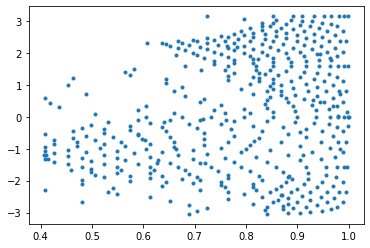

In [28]:
#Here is the real code:
#mussimData=pd.read_hdf("./MNTmceqFlus.h5")
listofpoints_alpha=[]
listofpoints_beta=[]
tmpdict={}
alphas = mussimData.alpha
betas = mussimData.beta
for i in range(0,len(alphas)):
     tmpdict[alphas[i],betas[i]]=True
AllAlphasBetas=tmpdict.keys()
for k in AllAlphasBetas:
    listofpoints_alpha.append(k[0])
    listofpoints_beta.append(k[1])

Text(0, 0.5, 'beta')

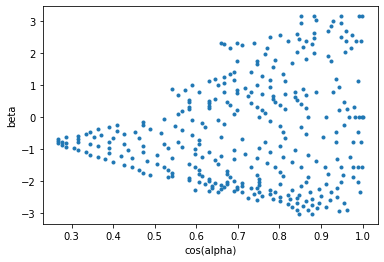

In [29]:
plt.plot(np.cos(np.array(listofpoints_alpha)),np.array(listofpoints_beta),'.')
plt.xlabel("cos(alpha)")
plt.ylabel("beta")



In [30]:

UnitVectors=[]
d2r=1

# Make 3D unit vectors on the sphere for each point available
for i in range(0, len(listofpoints_alpha)):
    UnitVectors.append([np.sin(listofpoints_alpha[i]*d2r)*np.cos(listofpoints_beta[i]*d2r),np.sin(listofpoints_alpha[i]*d2r)*np.sin(listofpoints_beta[i]*d2r),np.cos(listofpoints_alpha[i]*d2r)]) 

#This function finds the closest available (a,b) on the sphere to the one we have provided
def ClosestPoint(a,b):
    ThisUnitVector=[np.sin(a)*np.cos(b),np.sin(a)*np.sin(b),np.cos(a)]
    dotprods=[np.abs(ThisUnitVector[0]*UnitVectors[i][0]+ThisUnitVector[1]*UnitVectors[i][1]+ThisUnitVector[2]*UnitVectors[i][2]) for i in range(0,len(UnitVectors))]
    closest=np.argmax(dotprods)
    return listofpoints_alpha[closest],listofpoints_beta[closest],closest

In [31]:
#Get a continously interpolated F(E) function for nearest a and b
def GetEnergyFunction(a,b,EPower=3):
    ECut=1e5
    besta,bestb,idx=ClosestPoint(a,b)
    dataSubSet=mussimData[(mussimData.alpha==besta) & (mussimData.beta==bestb) & (mussimData.Energies<ECut)]
    interpfun= interpolate.interp1d(dataSubSet.Energies,dataSubSet.MuFLux)
    returnfunction=lambda E: interpfun(E)/E**EPower
    return returnfunction

In [32]:
#Integrate the continuous flux function near to (a,b) between these limits
def GetFluxIntegral(a,b,EMin,EMax):
    EnergyFunction=GetEnergyFunction(a,b)
    return integrate.quad(EnergyFunction,EMin,EMax)

#An option to provide (a,b) in units of degrees rather than radians
def GetFluxIntegralDeg(a,b,EMin,EMax):
    return GetFluxIntegral(a*d2r,b*d2r,EMin,EMax)

In [33]:
#Example flux integral - result is in units muons cm^-2 s^-1 sr^-1
GetFluxIntegralDeg(22,15,100,500)

(9.767725433884997e-06, 1.0328977071225739e-08)

In [34]:
EBins=np.logspace(-1,4,6)



In [35]:
np.cos(listofpoints_alpha)

array([0.43568245, 0.69670671, 0.95533649, 0.86781918, 0.91308894,
       0.81387846, 0.997551  , 0.9637709 , 0.62941203, 0.84725511,
       0.75180573, 0.7451744 , 0.39015168, 0.77757272, 0.71791067,
       0.54030231, 0.75836188, 0.58978803, 0.85770868, 0.52336595,
       0.48887208, 0.62941203, 0.65243747, 0.27712088, 0.84190098,
       0.62941203, 0.91712082, 0.31532236, 0.9637709 , 0.97133797,
       0.80802751, 0.71091354, 0.86280707, 0.80209576, 0.97589745,
       0.68222121, 0.65243747, 0.46248537, 0.66746283, 0.64482655,
       0.69670671, 0.86280707, 0.57351999, 0.34364575, 0.98006658,
       0.38092482, 0.80802751, 0.55702255, 0.76484219, 0.26749883,
       0.46248537, 0.81387846, 0.68222121, 0.73846856, 0.58978803,
       0.72483601, 0.73168887, 0.83646265, 0.75836188, 0.93937271,
       0.98877108, 0.85770868, 0.88233286, 0.58168309, 0.85252452,
       0.88699492, 0.75180573, 0.59783398, 0.45359612, 0.83094068,
       0.68222121, 0.7451744 , 0.66746283, 0.68949843, 0.59783

In [36]:
#Plot muon fluxes vs energy
cosa_sample=np.arange(0.4,1.02,0.02)
a_sample=np.arccos(cosa_sample-1e-2)
b_sample=np.linspace(-np.pi,np.pi,30)
cosa_mesh, b_mesh=np.meshgrid(b_sample,cosa_sample)
fluxmeshes=[]


for iE in range(0,len(EBins)-1):

    fluxmesh = np.zeros_like(cosa_mesh)
    print("Integrating fluxes for "+ str(EBins[iE])+ " < E < " + str(EBins[iE+1]))
    for ia in range(0,len(a_sample)):
        for ib in range(0,len(b_sample)):
            a=a_sample[ia]
            b=b_sample[ib]
            fluxmesh[ia,ib] = GetFluxIntegral(a,b,EBins[iE],EBins[iE+1])[0]
    fluxmeshes.append(fluxmesh)        

    

Integrating fluxes for 0.1 < E < 1.0
Integrating fluxes for 1.0 < E < 10.0


<ipython-input-32-fab79ddc1200>:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(EnergyFunction,EMin,EMax)
<ipython-input-32-fab79ddc1200>:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(EnergyFunction,EMin,EMax)
<ipython-input-32-fab79ddc1200>:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(EnergyFunction,EMin,EMax)
<ipython-input-32-fab79ddc1200>:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(EnergyFunction,EMin,EM

<ipython-input-32-fab79ddc1200>:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(EnergyFunction,EMin,EMax)
<ipython-input-32-fab79ddc1200>:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(EnergyFunction,EMin,EMax)
<ipython-input-32-fab79ddc1200>:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(EnergyFunction,EMin,EMax)
<ipython-input-32-fab79ddc1200>:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(EnergyFunction,EMin,EM

<ipython-input-32-fab79ddc1200>:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(EnergyFunction,EMin,EMax)
<ipython-input-32-fab79ddc1200>:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(EnergyFunction,EMin,EMax)
<ipython-input-32-fab79ddc1200>:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(EnergyFunction,EMin,EMax)
<ipython-input-32-fab79ddc1200>:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(EnergyFunction,EMin,EM

Integrating fluxes for 10.0 < E < 100.0
Integrating fluxes for 100.0 < E < 1000.0
Integrating fluxes for 1000.0 < E < 10000.0


In [37]:
cosa_sample

array([0.4 , 0.42, 0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 ,
       0.62, 0.64, 0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82,
       0.84, 0.86, 0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ])

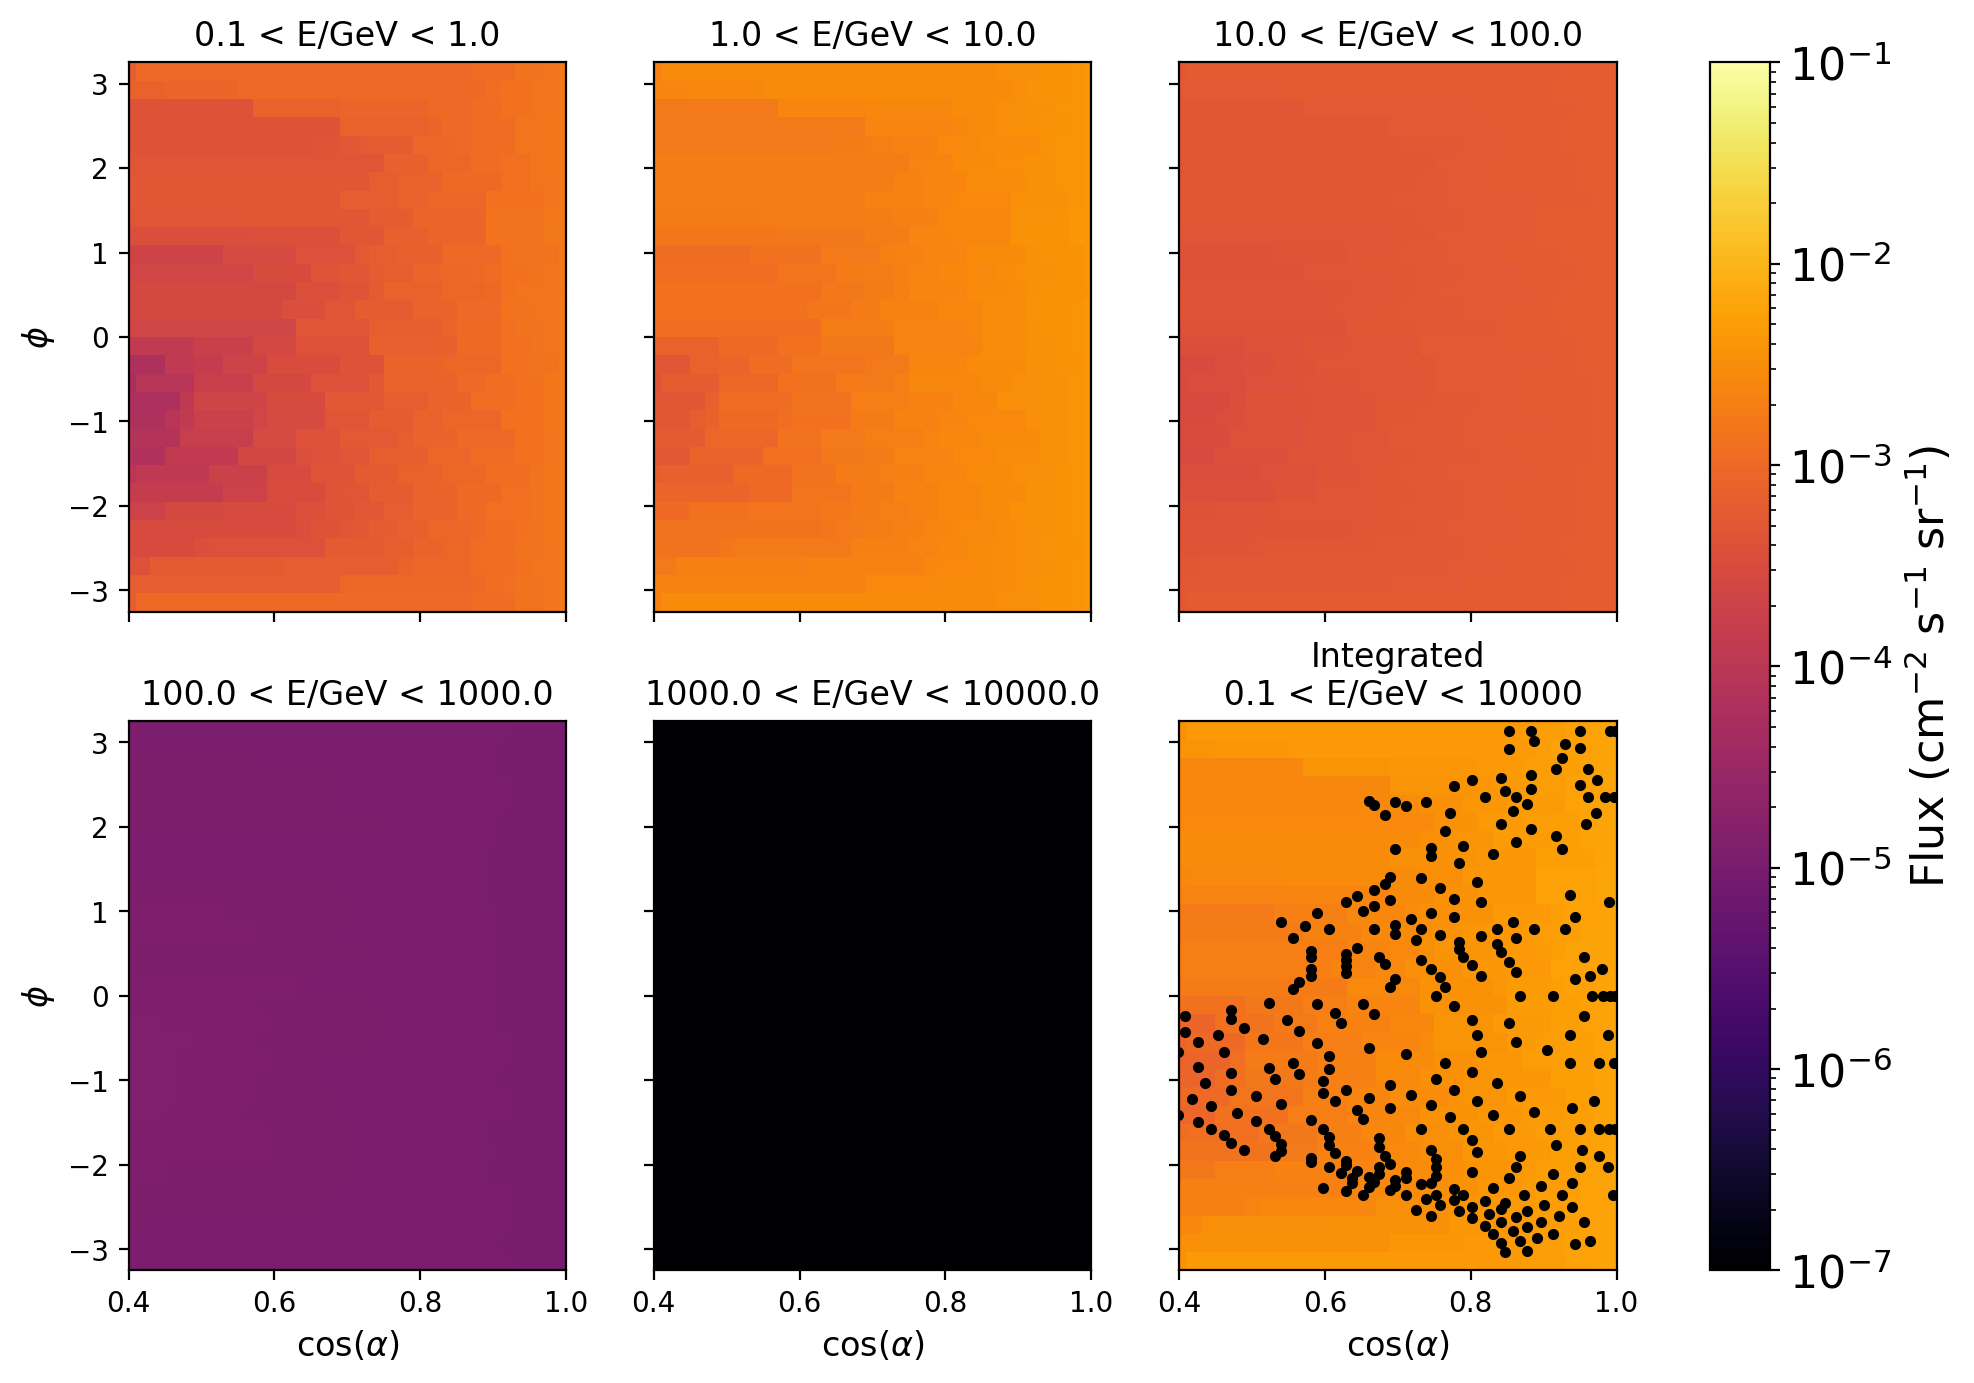

In [38]:
nstart=3
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(12,8),dpi=200, sharex=True, sharey=True)
for iax in range(0,len(axes.flat)-1):
    ax=axes.flatten()[iax]
    im=ax.pcolormesh(cosa_sample,b_sample,np.transpose(fluxmeshes[iax]),norm=mpl.colors.LogNorm(vmin=1e-7, vmax=1e-1),cmap='inferno',shading='auto')
    ax.set_title(str(EBins[iax])+ " < E/GeV < " + str(EBins[iax+1]))
    ax.set_xlim(0.4,1)
cbar=fig.colorbar(im, ax=axes.ravel().tolist(),label='Flux (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)')
cbar.set_label('Flux (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)',fontsize=16)
cbar.ax.tick_params(labelsize=16)
totalflux=np.zeros_like(fluxmeshes[0])
for m in fluxmeshes:
    totalflux+=m
ax=axes.flatten()[-1]
im=ax.pcolormesh(cosa_sample,b_sample,np.transpose(totalflux),norm=mpl.colors.LogNorm(vmin=1e-7, vmax=1e-1),cmap='inferno',shading='auto')
ax.set_title("Integrated\n 0.1 < E/GeV < 10000")
ax.plot(np.cos(np.array(listofpoints_alpha)*d2r),np.array(listofpoints_beta)*d2r,'.',color='black')
axes[1,0].set_xlabel(r"cos($\alpha$)",fontsize=12)
axes[1,1].set_xlabel(r"cos($\alpha$)",fontsize=12)
axes[1,2].set_xlabel(r"cos($\alpha$)",fontsize=12)

axes[1,0].set_ylabel(r"$\phi$",fontsize=12)
axes[0,0].set_ylabel(r"$\phi$",fontsize=12)

plt.savefig("MCEgFluxFix.png",dpi=200)

In [48]:
fluxmeshes_fine=[]
#EBins_fine=np.logspace(-1,3,20)

#Binning to match to proposal code
BinCenters=np.array([100,300,400,450,500,550,600,650,700,800,1000,2000,4000,6000])


EBins_fine=(BinCenters[1:]+BinCenters[:-1])/2

for iE in range(0,len(EBins_fine)-1):

    fluxmesh = np.zeros_like(cosa_mesh)
    print("Integrating fluxes for "+ str(EBins_fine[iE])+ " < E < " + str(EBins_fine[iE+1]))
    for ia in range(0,len(a_sample)):
        for ib in range(0,len(b_sample)):
            
            a=a_sample[ia]
            b=b_sample[ib]
            fluxmesh[ia,ib] = GetFluxIntegral(a,b,EBins_fine[iE],EBins_fine[iE+1])[0]
    fluxmeshes_fine.append(fluxmesh)  

Integrating fluxes for 200.0 < E < 350.0
Integrating fluxes for 350.0 < E < 425.0
Integrating fluxes for 425.0 < E < 475.0
Integrating fluxes for 475.0 < E < 525.0
Integrating fluxes for 525.0 < E < 575.0
Integrating fluxes for 575.0 < E < 625.0
Integrating fluxes for 625.0 < E < 675.0
Integrating fluxes for 675.0 < E < 750.0
Integrating fluxes for 750.0 < E < 900.0
Integrating fluxes for 900.0 < E < 1500.0
Integrating fluxes for 1500.0 < E < 3000.0
Integrating fluxes for 3000.0 < E < 5000.0


Text(0.5, 0, 'E (GeV)')

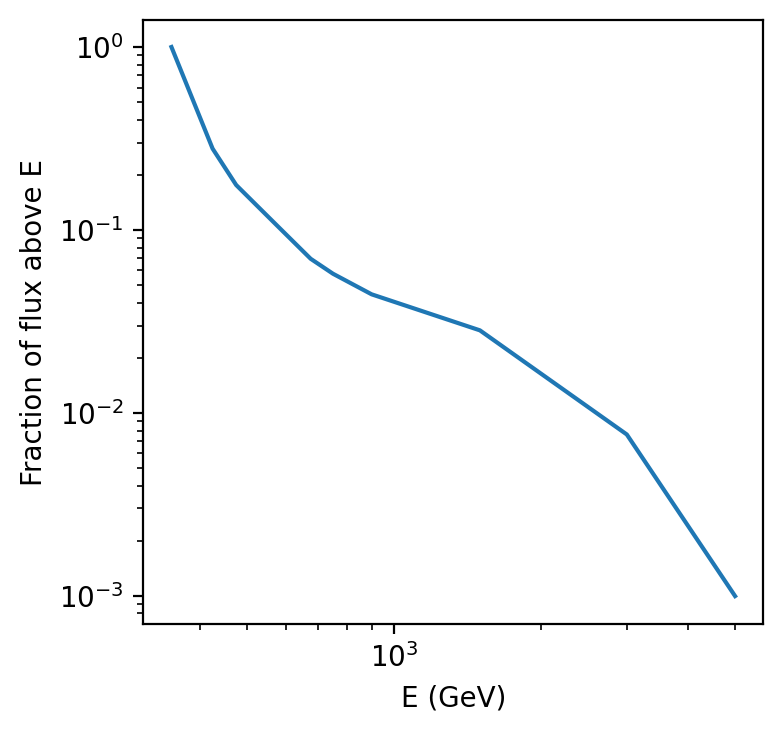

In [49]:
plt.figure(figsize=(4,4),dpi=200)
SummedFluxes=[sum(sum(x)) for x in fluxmeshes_fine]
plt.plot(np.flip(EBins_fine[1:]),np.cumsum(np.flip(SummedFluxes))/sum(SummedFluxes))
plt.loglog()
plt.ylabel("Fraction of flux above E")
plt.xlabel("E (GeV)")

In [50]:
f=open("MCEqFluxMeshes.pkl","wb")
pickle.dump([BinCenters,cosa_sample,b_sample,fluxmeshes_fine],f)
f.close()

In [51]:
BinCenters

array([ 100,  300,  400,  450,  500,  550,  600,  650,  700,  800, 1000,
       2000, 4000, 6000])

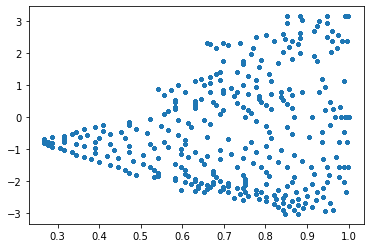

In [43]:
plt.plot(np.cos(mussimData.alpha*d2r),mussimData.beta*d2r,'.')

In [44]:
plt.figure(figsize=(5,5),dpi=150)
plt.scatter(mussimData.beta*d2r,np.cos(mussimData.alpha*d2r),s=2,c=mussimData.)
#plt.colorbar()
#plt.clim(0,1)
plt.xlabel(r"$\beta$")
plt.ylabel(r"cos$\alpha$")
plt.ylim(0.4,1)
plt.plot([-np.pi,np.pi],[0.4,0.4],color='red')
plt.xlim(-np.pi,np.pi)

SyntaxError: invalid syntax (<ipython-input-44-4bb084475296>, line 2)

In [ ]:
plt.hist(mussimData.alpha.unique())